In [1]:
!module load cuda/11.1

%matplotlib inline
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import gin
from PIL import Image

import collections
import functools
import os
import time
from typing import Any, Dict, Optional, Sequence

from absl import app
from absl import flags
from absl import logging
from flax import jax_utils
from flax import optim
from flax.metrics import tensorboard
from flax.training import checkpoints
import gin
import jax
from jax import numpy as jnp
from jax import random
from jax.config import config
import numpy as np
import tensorflow as tf
import tensorflow_hub as tf_hub
import pdb
import glob
import imageio

from hypernerf import configs
from hypernerf import datasets
from hypernerf import evaluation
from hypernerf import gpath
from hypernerf import image_utils
from hypernerf import model_utils
from hypernerf import models
from hypernerf import types
from hypernerf import utils
from hypernerf import visualization as viz

log_path = pathlib.Path('log/kubric_multi_car_rand/tune/small_skewness_2_gt/003')
rendering_path = log_path / 'renders-eval/00100000/train/train'
data_path = pathlib.Path('data/kubric_multi_car_rand/')
gt_path = data_path / 'groundtruth'
config_path = log_path / 'source.gin'

gin.parse_config_files_and_bindings(
  config_files=[str(config_path)],
  bindings=f"data_dir='{str(data_path)}'",
  skip_unknown=True)

# Load configurations.
exp_config = configs.ExperimentConfig()
train_config = configs.TrainConfig()
eval_config = configs.EvalConfig()

if train_config.use_decompose_nerf:
    dummy_model = models.DecomposeNerfModel({}, 0, 0)
else:
    dummy_model = models.NerfModel({}, 0, 0)

datasource = exp_config.datasource_cls(
  image_scale=exp_config.image_scale,
  random_seed=exp_config.random_seed,
  # Enable metadata based on model needs.
  use_warp_id=dummy_model.use_warp,
  use_appearance_id=(
      dummy_model.nerf_embed_key == 'appearance'
      or dummy_model.hyper_embed_key == 'appearance'),
  use_camera_id=dummy_model.nerf_embed_key == 'camera',
  use_time=dummy_model.warp_embed_key == 'time',
  mask_interest_region=exp_config.mask_interest_region)

# read gif masks
mask_gif = imageio.get_reader(str(rendering_path / 'mask.gif'))
mask_preds = []
for frame in mask_gif:
    if len(frame.shape) <= 2:
        frame = frame[...,None] * np.ones([1,1,3])
    mask_preds.append(frame)
mask_preds = np.array(mask_preds) / 255

# read blendw gif
blendw_gif = imageio.get_reader(str(rendering_path / 'blendw.gif'))
blendw_preds = []
for frame in blendw_gif:
    if len(frame.shape) <= 2:
        frame = frame[...,None] * np.ones([1,1,3])
    blendw_preds.append(frame)
blendw_preds = np.array(blendw_preds) / 255

train_eval_ids = utils.strided_subset(
  datasource.train_ids, eval_config.num_train_eval) # returns eval_config.num_train_eval+1 evenly spaced samples 
train_eval_iter = datasource.create_iterator(train_eval_ids, batch_size=0)

# convert all batchs into a list for easy access
train_eval_batches = [ batch for (item_id, batch) in zip(train_eval_ids, train_eval_iter)] 

train_eval_ids


2022-04-12 14:59:30.870579: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/software/spack/spack-0.11.2/opt/spack/linux-rhel7-x86_64/gcc-5.4.0/openmpi-1.10.7-jdc7f4fjdq5roxhadufd6h66xkwuytss/lib:/usr/local/software/spack/spack-0.11.2/opt/spack/linux-rhel7-x86_64/gcc-4.8.5/gcc-5.4.0-fis24ggupugiobii56fesif2y3qulpdr/lib64:/usr/local/software/spack/spack-0.11.2/opt/spack/linux-rhel7-x86_64/gcc-4.8.5/gcc-5.4.0-fis24ggupugiobii56fesif2y3qulpdr/lib:/usr/local/Cluster-Apps/cuda/8.0/lib64:/usr/local/Cluster-Apps/cuda/8.0/lib:/usr/local/software/global/lib:/usr/local/Cluster-Apps/vgl/2.5.1/64/lib:/usr/local/software/slurm/current/lib
2022-04-12 14:59:30.993386: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so

['rgba_00000',
 'rgba_00001',
 'rgba_00002',
 'rgba_00003',
 'rgba_00004',
 'rgba_00005',
 'rgba_00006',
 'rgba_00007',
 'rgba_00008',
 'rgba_00009',
 'rgba_00010',
 'rgba_00011',
 'rgba_00012',
 'rgba_00013',
 'rgba_00014',
 'rgba_00015',
 'rgba_00016',
 'rgba_00017',
 'rgba_00018',
 'rgba_00019',
 'rgba_00020',
 'rgba_00021',
 'rgba_00022',
 'rgba_00023',
 'rgba_00024',
 'rgba_00025',
 'rgba_00026',
 'rgba_00027',
 'rgba_00028',
 'rgba_00029',
 'rgba_00030',
 'rgba_00031',
 'rgba_00032',
 'rgba_00033',
 'rgba_00034',
 'rgba_00035',
 'rgba_00036',
 'rgba_00037',
 'rgba_00038',
 'rgba_00039',
 'rgba_00040',
 'rgba_00041',
 'rgba_00042',
 'rgba_00043',
 'rgba_00044',
 'rgba_00045',
 'rgba_00046',
 'rgba_00047',
 'rgba_00048',
 'rgba_00049',
 'rgba_00050',
 'rgba_00051',
 'rgba_00052',
 'rgba_00053',
 'rgba_00054',
 'rgba_00055',
 'rgba_00056',
 'rgba_00057',
 'rgba_00058',
 'rgba_00059',
 'rgba_00060',
 'rgba_00061',
 'rgba_00062',
 'rgba_00063',
 'rgba_00064',
 'rgba_00065',
 'rgba_000

In [3]:
def compute_jaccard_index(mask_pred, mask_gt):
    # deal with region of interest
    mask_pred = mask_pred.reshape(-1)
    mask_gt = mask_gt.reshape(-1)
    mask_pred = mask_pred[mask_gt != -1]
    mask_gt = mask_gt[mask_gt != -1]
    
    tp = np.sum(mask_pred * mask_gt)
    fp = np.sum(mask_pred * (1-mask_gt))
    fn = np.sum((1-mask_pred) * mask_gt)
    return tp / (tp + fn + fp)

def compute_f1(mask_pred, mask_gt):
    # Compute F measure 

    # deal with region of interest
    mask_pred = mask_pred.reshape(-1)
    mask_gt = mask_gt.reshape(-1)
    mask_pred = mask_pred[mask_gt != -1]
    mask_gt = mask_gt[mask_gt != -1]

    tp = np.sum(mask_pred * mask_gt)
    fp = np.sum(mask_pred * (1-mask_gt))
    fn = np.sum((1-mask_pred) * mask_gt)
    return tp / (tp + 0.5 * (fn + fp))

In [4]:
%matplotlib inline

ID = 120
print(train_eval_ids[ID])
batch = train_eval_batches[ID]
# mask_pred = mask_preds[ID]
mask_pred = np.where(blendw_preds[ID] > 0.5, 1., 0.)
blendw_pred = blendw_preds[ID]
# mask_gt = np.where(batch['mask'] == -1, 0.5, batch['mask'])[...,0]
mask_gt = batch['mask'][..., 0]

fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(mask_gt, vmin=-1, vmax=1)
ax[1].imshow(mask_pred, vmin=-1, vmax=1)
ax[2].imshow(blendw_pred, vmin=-1, vmax=1)
plt.show()



000136


KeyError: 'mask'

in000121


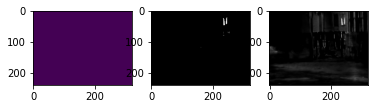

In [4]:
%matplotlib inline

ID = 120
print(train_eval_ids[ID])
batch = train_eval_batches[ID]
# mask_pred = mask_preds[ID]
mask_pred = np.where(blendw_preds[ID] > 0.5, 1., 0.)
blendw_pred = blendw_preds[ID]
# mask_gt = np.where(batch['mask'] == -1, 0.5, batch['mask'])[...,0]
mask_gt = batch['mask'][..., 0]

fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(mask_gt, vmin=-1, vmax=1)
ax[1].imshow(mask_pred, vmin=-1, vmax=1)
ax[2].imshow(blendw_pred, vmin=-1, vmax=1)
plt.show()



In [14]:
jacs = []
f1s = []
for i in range(len(train_eval_batches)):
    batch = train_eval_batches[i]
#     mask_pred = mask_preds[i]
    mask_pred = np.where(blendw_preds[i] > 0.5, 1., 0.)
    mask_gt = batch['mask'][..., 0]
    jacs.append(compute_jaccard_index(mask_pred, mask_gt))
    f1s.append(compute_f1(mask_pred, mask_gt))
    
jacs = np.array(jacs)
f1s = np.array(f1s)

print(f'Jac: {jacs[np.logical_not(np.isnan(jacs))].mean()}')
print(f'F1: {f1s[np.logical_not(np.isnan(f1s))].mean()}')

/tmp/ipykernel_30019/2279679354.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return tp / (tp + fn + fp)
/tmp/ipykernel_30019/2279679354.py:25: RuntimeWarning: invalid value encountered in double_scalars
  return tp / (tp + 0.5 * (fn + fp))


Jac: 0.7640530655018691
F1: 0.8337748802406741


In [11]:
masks = []

for i in range(len(train_eval_batches)):
    mask_pred = np.where(blendw_preds[i] > 0.1, 1., 0.)
    masks.append(mask_pred)
    
masks = np.array(masks)

In [13]:
imageio.mimsave('mask.gif', masks, format='GIF', duration=1/100)

In [6]:
print(f'Jac: {jacs[np.logical_not(np.isnan(jacs))].mean()}')
print(f'F1: {f1s[np.logical_not(np.isnan(f1s))].mean()}')

Jac: 0.7747651247031835
F1: 0.8322865324085997


# store input gif

In [2]:
# store input gif
rgbs = []
for i in range(len(train_eval_batches)):
    batch = train_eval_batches[i]
    rgbs.append(batch['rgb'])
    
n_img = len(rgbs)
with imageio.get_writer(data_path / 'input.gif', fps= max(n_img // 10, 1), mode='I') as writer:
    for rgb in rgbs:
        writer.append_data(rgb)
